In [1]:
# see https://github.com/JustGlowing/minisom/blob/master/examples/HexagonalTopology.ipynb
# maybe look at this??? https://github.com/JustGlowing/minisom/blob/master/examples/DemocracyIndex.ipynb
from minisom import MiniSom

import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

In [2]:
input_dir_w6 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup6/"
# Load dataset

train_embeddings = np.load(input_dir_w6+'scBaseEncoderFeat_Z_bs250_tau0.5.npy')
print(train_embeddings.shape)

(41093, 5)


In [3]:
input_dir_w5 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/"

adata_train = ad.read_h5ad(input_dir_w5+'Larry_41093_2000_norm_log_cleaned.h5ad')

# adata_train.obs['Cell type annotation'] = adata_train.obs["cell_type"]
# adata_test.obs['Cell type annotation'] = adata_test.obs["cell_type"]
train_labels = adata_train.obs["clone_id"].to_numpy()
print(train_labels.shape)

(41093,)


In [4]:
# Create a boolean mask based on the condition in adata_train
mask = (adata_train.obs["time_info"] == 2.0)
# Subset adata_train based on the mask
adata_subset = adata_train[mask]

# Subset train_embeddings based on the same mask
train_embeddings_subset = train_embeddings[mask.to_numpy()]

In [5]:
som = MiniSom(15, 15,train_embeddings_subset.shape[1] , sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(train_embeddings_subset, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.13633392490201304


In [6]:
# Get the weights of the SOM after training
weights = som.get_weights()

# Calculate the U-matrix for visualization
umatrix = som.distance_map()

Get the lineage assignments

In [7]:
# Load the metadata file
metadata_file = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup6/LARRY_tabulate-lineages.csv"
metadata_df = pd.read_csv(metadata_file, sep=",")
metadata_df

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,nCount_originalexp,nFeature_originalexp,Library,Cell.barcode,time_info,Starting.population,state_info,Well,SPRING.x,SPRING.y,Time.point,clone_id,n_genes,assignment
0,d6_2_2:GCGTGCAAAGAAGTTA,d6,462,195,462,195,d6_2_2,GCGTGCAA-AGAAGTTA,6,Lin-Kit+Sca1-,Undifferentiated,2,411.496,-96.190,6,Lineage_573,4050,Other
1,d6_2_2:AAGGGACCCTCGATGC,d6,681,261,681,261,d6_2_2,AAGGGACC-CTCGATGC,6,Lin-Kit+Sca1-,Undifferentiated,2,-587.462,-306.925,6,Lineage_1440,3139,Other
2,d6_2_2:CGTACCGAAGCGCCTT,d6,403,159,403,159,d6_2_2,CGTACCGA-AGCGCCTT,6,Lin-Kit+Sca1-,Monocyte,2,1429.805,-429.300,6,Lineage_394,2403,Other
3,d6_2_2:CCGTAGCTAGGCAGTT,d6,178,90,178,90,d6_2_2,CCGTAGCT-AGGCAGTT,6,Lin-Kit+Sca1-,Undifferentiated,2,-1169.594,362.010,6,Lineage_1972,1608,Other
4,d6_2_2:TAGGCTTTCGTGGATA,d6,975,111,975,111,d6_2_2,TAGGCTTT-CGTGGATA,6,Lin-Kit+Sca1-,Neutrophil,2,1236.039,-2113.013,6,Lineage_1450,1667,Undifferentiated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41088,LSK_d6_1_3:CTGTGACCTGCTATTT,LSK,234,124,234,124,LSK_d6_1_3,CTGTGACC-TGCTATTT,6,Lin-Kit+Sca1+,Undifferentiated,1,307.879,-27.451,6,Lineage_4999,2432,Other
41089,LSK_d6_1_3:AGGCGTTTCCTATTCA,LSK,225,120,225,120,LSK_d6_1_3,AGGCGTTT-CCTATTCA,6,Lin-Kit+Sca1+,Undifferentiated,1,-1074.917,441.981,6,Lineage_12,1876,Other
41090,LSK_d6_1_3:CGTGCAACTGGCCTGT,LSK,111,65,111,65,LSK_d6_1_3,CGTGCAAC-TGGCCTGT,6,Lin-Kit+Sca1+,Undifferentiated,1,247.634,281.262,6,Lineage_267,1434,Other
41091,LSK_d6_1_3:CCCTTGCAAGTGAAAG,LSK,219,107,219,107,LSK_d6_1_3,CCCTTGCA-AGTGAAAG,6,Lin-Kit+Sca1+,Neutrophil,1,353.734,-980.246,6,Lineage_3534,1252,Other


In [8]:
# Concatenate 'Library' and 'Cell barcode' in filtered_metadata to create unique barcodes
metadata_df['combined_barcode'] = metadata_df['Library'] + ':' + metadata_df['Cell.barcode']

In [9]:
# Convert the 'Library' and 'Cell barcode' columns to string before concatenating
adata_subset.obs['Library_str'] = adata_subset.obs['Library'].astype(str)
adata_subset.obs['Cell barcode_str'] = adata_subset.obs['Cell barcode'].astype(str)

# Ensure 'adata' also has 'Library' and 'Cell barcode' columns in the same format
# Create a new 'combined_barcode' column in adata
adata_subset.obs['combined_barcode'] = adata_subset.obs['Library_str'] + ':' + adata_subset.obs['Cell barcode_str']

/tmp/ipykernel_3764332/579885139.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['Library_str'] = adata_subset.obs['Library'].astype(str)


In [10]:
adata_subset

AnnData object with n_obs × n_vars = 1746 × 2000
    obs: 'Library', 'Cell barcode', 'time_info', 'Starting population', 'state_info', 'Well', 'SPRING-x', 'SPRING-y', 'Time point', 'clone_id', 'n_genes', 'Library_str', 'Cell barcode_str', 'combined_barcode'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'data_des', 'hvg', 'log1p'
    obsm: 'X_clone', 'X_emb'
    layers: 'raw_counts'

In [11]:
import pandas as pd

# Convert adata.obs to a pandas DataFrame
adata_obs_df = adata_subset.obs.copy()

# Merge with metadata_df on the 'Cell barcode' column
merged_df = adata_obs_df.merge(metadata_df[['combined_barcode', 'assignment']], 
                               left_on='combined_barcode', right_on='combined_barcode', 
                               how='left')

In [12]:
merged_df

,Library,Cell barcode,time_info,Starting population,state_info,Well,SPRING-x,SPRING-y,Time point,clone_id,n_genes,Library_str,Cell barcode_str,combined_barcode,assignment
0,d2_3,GCGCTGAT-TAGCCTCG,2.0,Lin-Kit+Sca1-,Undifferentiated,0,528.582,638.338,2,1626,1574,d2_3,GCGCTGAT-TAGCCTCG,d2_3:GCGCTGAT-TAGCCTCG,Undifferentiated
1,d2_3,CGTTGCCT-CACAGTTT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,130.474,452.106,2,5039,2061,d2_3,CGTTGCCT-CACAGTTT,d2_3:CGTTGCCT-CACAGTTT,Other
2,d2_3,CATGCTGC-CGCTAATA,2.0,Lin-Kit+Sca1-,Undifferentiated,0,576.775,-637.379,2,2757,4418,d2_3,CATGCTGC-CGCTAATA,d2_3:CATGCTGC-CGCTAATA,Other
3,d2_3,CCGACTTT-CTTCTTCG,2.0,Lin-Kit+Sca1-,Undifferentiated,0,-488.527,-164.161,2,3627,2741,d2_3,CCGACTTT-CTTCTTCG,d2_3:CCGACTTT-CTTCTTCG,Other
4,d2_3,CGTCGAAT-TTCCGAGT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,481.179,-191.860,2,1949,1442,d2_3,CGTCGAAT-TTCCGAGT,d2_3:CGTCGAAT-TTCCGAGT,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,LK_d2,CCCTTGCA-TTGGCGTT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,288.141,136.957,2,3016,2579,LK_d2,CCCTTGCA-TTGGCGTT,LK_d2:CCCTTGCA-TTGGCGTT,Other
1742,LK_d2,GGTTACAC-CCGCAACT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,558.791,123.828,2,5801,1972,LK_d2,GGTTACAC-CCGCAACT,LK_d2:GGTTACAC-CCGCAACT,Other
1743,LK_d2,GCCTGGTA-TATTGCCT,2.0,Lin-Kit+Sca1-,Undifferentiated,0,1083.533,-221.292,2,352,585,LK_d2,GCCTGGTA-TATTGCCT,LK_d2:GCCTGGTA-TATTGCCT,Neutrophil
1744,LK_d2,GGGTCATT-TGCGTATC,2.0,Lin-Kit+Sca1-,Undifferentiated,0,77.843,302.044,2,5663,2599,LK_d2,GGGTCATT-TGCGTATC,LK_d2:GGGTCATT-TGCGTATC,Other


In [13]:
# Add the 'assignment' column back to adata.obs
adata_subset.obs['assignment'] = merged_df['assignment'].values

# Now adata.obs has the assignment column for each cell barcode present in adata

In [14]:
adata_subset.obs['assignment'].value_counts()

assignment
Other               1483
Neutrophil           103
Undifferentiated      85
Monocyte              75
Name: count, dtype: int64

In [15]:
# Optionally, subset the labels if needed
assignment_vec = adata_subset.obs['assignment'].to_numpy()

Plot SOM

In [20]:
# Set the amount of jitter (tune this as needed)
jitter_amount = 0.1

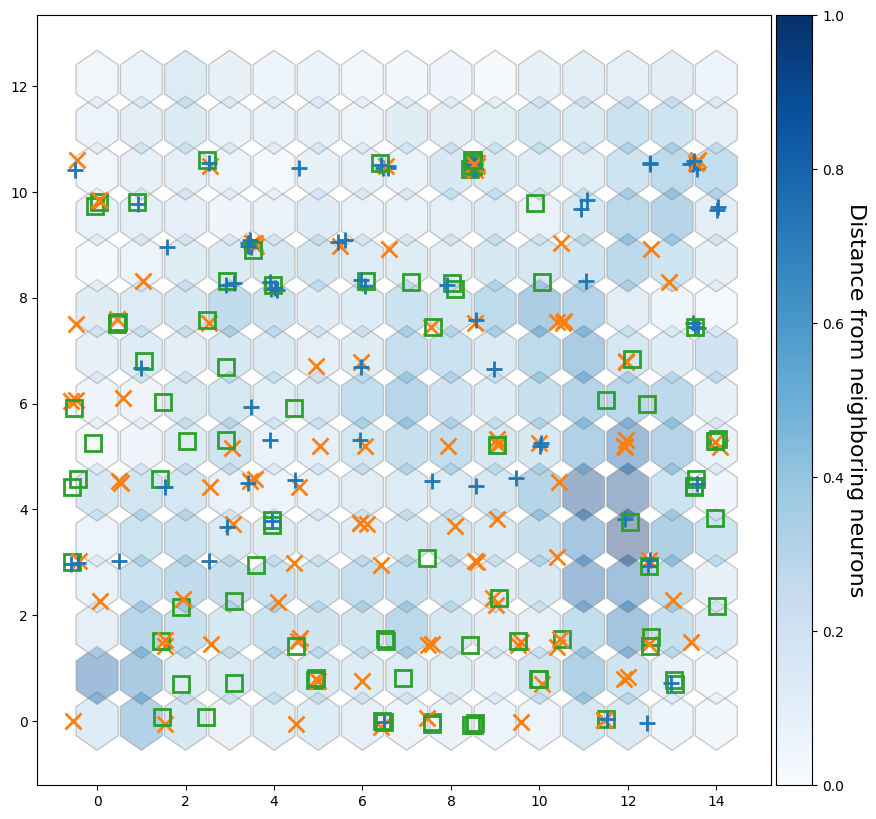

In [25]:
# Create a figure for the hexagonal grid visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        hex = RegularPolygon((i, j * np.sqrt(3) / 2), numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, edgecolor='gray')
        ax.add_patch(hex)

# Plot data points on the SOM grid
for cnt, x in enumerate(train_embeddings_subset):
    w = som.winner(x)  # Find the winning neuron
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2

    # Apply jitter to the coordinates
    wx = wx + np.random.uniform(-jitter_amount, jitter_amount)
    wy = wy + np.random.uniform(-jitter_amount, jitter_amount)

    label = assignment_vec[cnt]
    if label == "Monocyte":
        # Assign marker and color based on the label
        plt.plot(wx, wy, '+', 
                 markerfacecolor='None', markeredgecolor='C0', 
                 markersize=12, markeredgewidth=2)
    elif label == "Neutrophil":
        # Assign marker and color based on the label
        plt.plot(wx, wy, 'x', 
                 markerfacecolor='None', markeredgecolor='C1', 
                 markersize=12, markeredgewidth=2)
    elif label == "Undifferentiated":
        # Assign marker and color based on the label
        plt.plot(wx, wy, 's', 
                 markerfacecolor='None', markeredgecolor='C2', 
                 markersize=12, markeredgewidth=2)
    # else:
    #     # Plot all other points in light gray
    #     plt.plot(wx, wy, 'o', markerfacecolor='None', markeredgecolor='lightgray', 
    #              markersize=5, markeredgewidth=1)

# Add colorbar for U-matrix
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('Distance from neighboring neurons', 
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

plt.show()

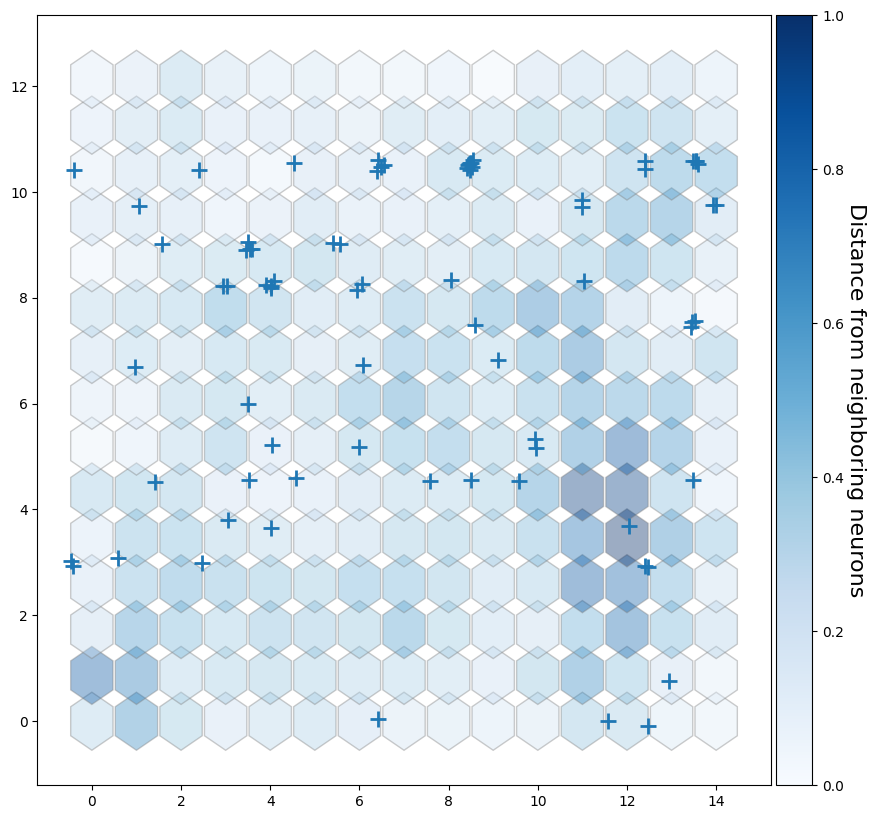

In [22]:
# Create a figure for the hexagonal grid visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        hex = RegularPolygon((i, j * np.sqrt(3) / 2), numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, edgecolor='gray')
        ax.add_patch(hex)

# Plot data points on the SOM grid
for cnt, x in enumerate(train_embeddings_subset):
    w = som.winner(x)  # Find the winning neuron
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2

    # Apply jitter to the coordinates
    wx = wx + np.random.uniform(-jitter_amount, jitter_amount)
    wy = wy + np.random.uniform(-jitter_amount, jitter_amount)

    label = assignment_vec[cnt]
    if label == "Monocyte":
        # Assign marker and color based on the label
        plt.plot(wx, wy, '+', 
                 markerfacecolor='None', markeredgecolor='C0', 
                 markersize=12, markeredgewidth=2)

# Add colorbar for U-matrix
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('Distance from neighboring neurons', 
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

plt.show()

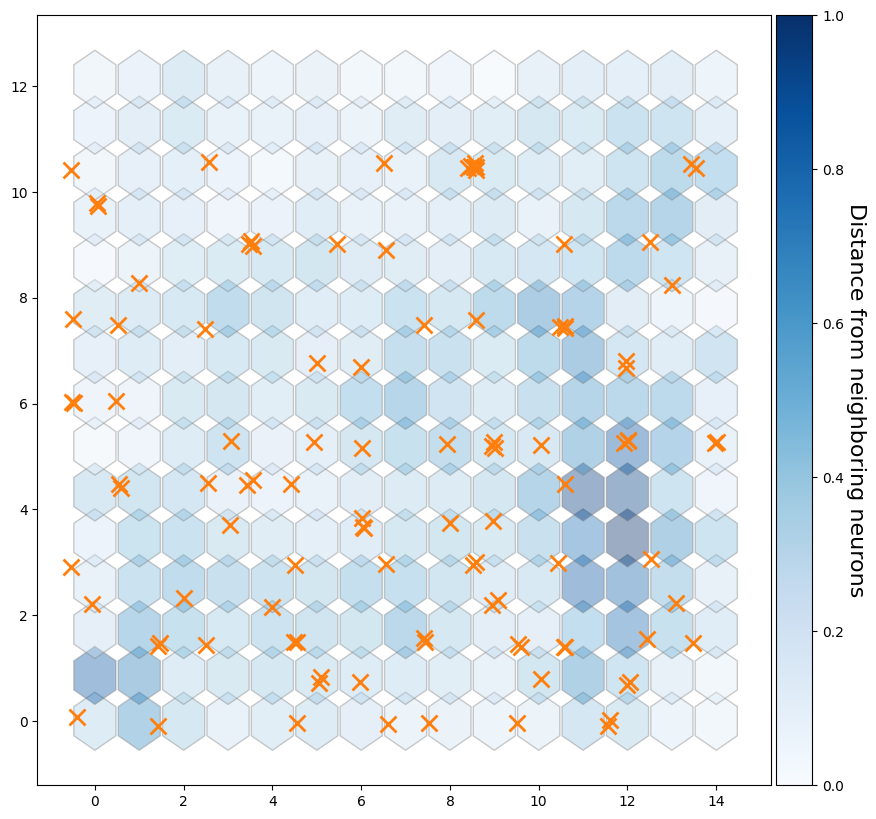

In [23]:
# Create a figure for the hexagonal grid visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        hex = RegularPolygon((i, j * np.sqrt(3) / 2), numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, edgecolor='gray')
        ax.add_patch(hex)

# Plot data points on the SOM grid
for cnt, x in enumerate(train_embeddings_subset):
    w = som.winner(x)  # Find the winning neuron
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2

    # Apply jitter to the coordinates
    wx = wx + np.random.uniform(-jitter_amount, jitter_amount)
    wy = wy + np.random.uniform(-jitter_amount, jitter_amount)

    label = assignment_vec[cnt]
    if label == "Neutrophil":
        # Assign marker and color based on the label
        plt.plot(wx, wy, 'x', 
                 markerfacecolor='None', markeredgecolor='C1', 
                 markersize=12, markeredgewidth=2)
                 
# Add colorbar for U-matrix
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('Distance from neighboring neurons', 
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

plt.show()

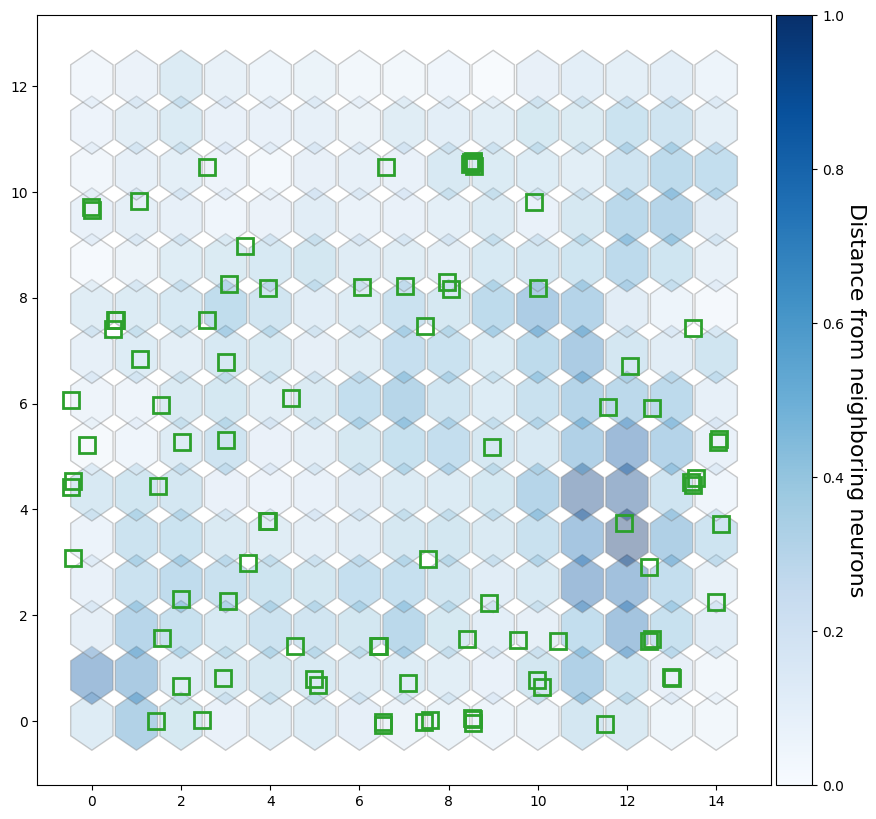

In [24]:
# Create a figure for the hexagonal grid visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        hex = RegularPolygon((i, j * np.sqrt(3) / 2), numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, edgecolor='gray')
        ax.add_patch(hex)

# Plot data points on the SOM grid
for cnt, x in enumerate(train_embeddings_subset):
    w = som.winner(x)  # Find the winning neuron
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2

    # Apply jitter to the coordinates
    wx = wx + np.random.uniform(-jitter_amount, jitter_amount)
    wy = wy + np.random.uniform(-jitter_amount, jitter_amount)

    label = assignment_vec[cnt]
    if label == "Undifferentiated":
        # Assign marker and color based on the label
        plt.plot(wx, wy, 's', 
                 markerfacecolor='None', markeredgecolor='C2', 
                 markersize=12, markeredgewidth=2)
                 
# Add colorbar for U-matrix
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('Distance from neighboring neurons', 
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

plt.show()